# Model
Pipeline that defines the model used to training and test the model specified.

# Download the dataset zip file
This section focus on the download do dataset to local machine.

Cleaning temporary directories

In [21]:
%rm -rf './sample_data' 'dataset' 'execution-logs' 'checkpoint' 'history.json'

Defining the global constants

In [22]:
class Constants(object):
  LOG_ENABLED = True
  LEARNING_RATE_DECAY = True
  LOG_PATH = './execution-logs'
  DRIVE_MOUNT_PATH = './gdrive'
  DRIVE_PATH = f'{DRIVE_MOUNT_PATH}/My Drive/Colab Notebooks'
  ZIP_DATASET_DRIVE_PATH = f'{DRIVE_PATH}/augmented-dataset.zip'
  DATASET_PATH = './dataset'
  TRAINING_DATASET_PATH = f'{DATASET_PATH}/train'
  VALIDATION_DATASET_PATH = f'{DATASET_PATH}/val'
  TEST_DATASET_PATH = f'{DATASET_PATH}/test'
  DRIVE_CHECKPOINT_PATH = f'{DRIVE_PATH}/checkpoint'
  CHECKPOINT_FILENAME = 'checkpoint'
  CHECKPOINT_PATH = f'./{CHECKPOINT_FILENAME}'
  DRIVE_MODEL_CHECKPOINT_PATH = f'{DRIVE_CHECKPOINT_PATH}/model'
  HISTORY_CHECKPOINT_FILENAME = 'history.json'
  HISTORY_CHECKPOINT_PATH = f'./{HISTORY_CHECKPOINT_FILENAME}'
  DRIVE_HISTORY_CHECKPOINT_PATH = f'{DRIVE_CHECKPOINT_PATH}/{HISTORY_CHECKPOINT_FILENAME}'
  BATCH_SIZE = 16
  IMAGE_HEIGHT = 224
  IMAGE_WIDTH = 224
  CHANNEL_SIZE = 3
  IMAGE_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, CHANNEL_SIZE)
  SEED = 133

Importing dependencies

In [23]:
from google.colab import drive
from zipfile import ZipFile
from glob import glob
from uuid import uuid4
from tqdm import tqdm
from psutil import cpu_count, cpu_stats, virtual_memory
from tensorflow.keras import backend
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.applications import InceptionResNetV2
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np
import shutil
import json
import os
import re

Log hardware specifications in `execution-logs` folder

In [24]:
def __log_hardware_info():
  from psutil import cpu_count, cpu_stats, virtual_memory
  import os

  # Create hardware-info directory
  if not os.path.exists(Constants.LOG_PATH):
    os.mkdir(Constants.LOG_PATH)

  # Log cpu informations
  %cat /proc/cpuinfo > './execution-logs/cpu.log'

  # Log general informations
  general_info = {
      'cpu_count': cpu_count(),
      'cpu_stats': cpu_stats(),
      'virtual_memory': virtual_memory()
  }
  with open(f'{Constants.LOG_PATH}/general.log', 'w') as file:
    file.write(str(general_info))

if Constants.LOG_ENABLED:
  __log_hardware_info()

Mounting Google Drive in this machine and copy the dataset folder from Google Drive mounted to current path

In [25]:
drive.mount(Constants.DRIVE_MOUNT_PATH, force_remount=True, timeout_ms=60000)

Mounted at ./gdrive


Copying from Google Drive the dataset to current path

In [26]:
zip_ref = ZipFile(Constants.ZIP_DATASET_DRIVE_PATH, 'r')
zip_ref.extractall(Constants.DATASET_PATH)
zip_ref.close()

# Create the model

Section dedicated to create the CNN model.

Define the training and validation dataset divisions.

In [27]:
def normalize_data(dataset):
  # Notice the pixel values are now in [min 0, max 1]
  normalization_layer = tf.keras.layers.Rescaling(1./255)
  return dataset.map(lambda x, y: (normalization_layer(x), y))

def get_training_dataset():
  return tf.keras.utils.image_dataset_from_directory(
      # Constants.DATASET_PATH,
      Constants.TRAINING_DATASET_PATH,
      # labels='inferred',
      label_mode='categorical',
      # validation_split=0.2,
      color_mode='rgb',
      shuffle=True,
      # subset="training",
      seed=Constants.SEED,
      image_size=(Constants.IMAGE_HEIGHT, Constants.IMAGE_WIDTH),
      batch_size=Constants.BATCH_SIZE
  )

def get_validation_dataset():
  return tf.keras.utils.image_dataset_from_directory(
      # Constants.DATASET_PATH,
      Constants.VALIDATION_DATASET_PATH,
      # labels='inferred',
      label_mode='categorical',
      # validation_split=0.2,
      color_mode='rgb',
      shuffle=True,
      # subset="validation",
      seed=Constants.SEED,
      image_size=(Constants.IMAGE_HEIGHT, Constants.IMAGE_WIDTH),
      batch_size=Constants.BATCH_SIZE
  )

def get_test_dataset():
  return tf.keras.utils.image_dataset_from_directory(
      # Constants.DATASET_PATH,
      Constants.TEST_DATASET_PATH,
      # labels='inferred',
      label_mode='categorical',
      # validation_split=0.2,
      color_mode='rgb',
      shuffle=True,
      # subset="validation",
      seed=Constants.SEED,
      image_size=(Constants.IMAGE_HEIGHT, Constants.IMAGE_WIDTH),
      # batch_size=Constants.BATCH_SIZE
  )

# Training dataset
training_dataset = get_training_dataset()
training_dataset_normalized = normalize_data(training_dataset)

# Validation dataset
validation_dataset = get_validation_dataset()

# Test dataset
test_dataset = get_test_dataset()

# Number of classes
number_class = len(training_dataset.class_names)

Found 4123 files belonging to 48 classes.
Found 169 files belonging to 48 classes.
Found 191 files belonging to 48 classes.


[Tune datasets](https://www.tensorflow.org/guide/data_performance) applying caching

In [28]:
AUTOTUNE = tf.data.AUTOTUNE
training_dataset = training_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Define the model architecture

In [29]:
def inception_resnet_model():
  model = InceptionResNetV2(input_shape=Constants.IMAGE_SHAPE, 
                            weights=None, 
                            classes=number_class)
  model.summary()

  model.compile(loss='categorical_crossentropy',
                optimizer=tf.optimizers.SGD(learning_rate=0.003, momentum=0.9, nesterov=False),
                metrics=['accuracy', 'top_k_categorical_accuracy'])
  return model

def inception_resnet_pretrained_model():
  model = InceptionResNetV2(input_shape=Constants.IMAGE_SHAPE, 
                            include_top=False, 
                            weights='imagenet', 
                            classes=number_class)
  
  x = GlobalAveragePooling2D(name='avg_pool')(model.output)
  x = Dense(number_class, activation='softmax', name='predictions')(x)

  model = Model(model.input, x)
  model.summary()

  model.compile(loss='categorical_crossentropy',
                      optimizer=tf.optimizers.SGD(learning_rate=0.003, momentum=0.9, nesterov=False),
                      metrics=['accuracy', 'top_k_categorical_accuracy'])
  return model

def baseline_model():
  # in parts taken from https://github.com/DeepABIS/deepabis
  image_input = Input(shape=Constants.IMAGE_SHAPE, name='input')

   # --- block 1 ---
  x = Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv1')(image_input)
  x = BatchNormalization()(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

  # --- block 2 ---
  x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
  x = BatchNormalization()(x)
  x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

  # --- coarse 1 branch ---
  # c_1_bch = Flatten(name='c1_flatten')(x)
  # c_1_bch = Dense(64, activation='relu', name='c1_fc_1')(c_1_bch)
  # c_1_bch = BatchNormalization()(c_1_bch)
  # c_1_bch = Dropout(0.5)(c_1_bch)
  # c_1_pred = Dense(number_class, activation='softmax', name='c1_predictions')(c_1_bch)

  # --- block 3 ---
  x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
  x = BatchNormalization()(x)
  x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

  # --- fine block ---
  x = Flatten(name='flatten')(x)
  x = Dense(256, activation='relu', name='fc_1')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.5)(x)
  x = Dense(256, activation='relu', name='fc_2')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.5)(x)
  fine_pred = Dense(number_class, activation='softmax', name='predictions')(x)

  # model = Model(inputs=image_input, outputs=[c_1_pred, fine_pred], name='bee_cnn')
  model = Model(inputs=image_input, outputs=[fine_pred], name='bee_cnn')
  model.summary()
  
  # --- loss_weights ---
  alpha = backend.variable(value=0.99, dtype="float32", name="alpha").numpy()
  beta = backend.variable(value=0.01, dtype="float32", name="beta").numpy()
  
  model.compile(loss='categorical_crossentropy', 
                optimizer=tf.optimizers.SGD(learning_rate=0.003, momentum=0.9, nesterov=False),
                # optimizer=tf.optimizers.Adam(),
                loss_weights=[alpha, beta],
                metrics=['accuracy', 'top_k_categorical_accuracy'])
  return model

Define functions to save or load model and history data from cloud.

In [30]:
def save_model_locally(model):
  if os.path.exists(Constants.CHECKPOINT_PATH):
    shutil.rmtree(Constants.CHECKPOINT_PATH)
  model.save(Constants.CHECKPOINT_FILENAME, save_format='tf')

def copy_model_in_cloud():
  if os.path.exists(Constants.DRIVE_CHECKPOINT_PATH):
    shutil.rmtree(Constants.DRIVE_MODEL_CHECKPOINT_PATH)
  shutil.copytree(Constants.CHECKPOINT_PATH, Constants.DRIVE_MODEL_CHECKPOINT_PATH)

def scientific_notation_to_decimal(x):
  return float("{:.8f}".format(float(x)))

def save_history_locally(history):
  history_rates = history.history
  learning_rates = history_rates['lr']
  history_rates['lr'] = list(map(scientific_notation_to_decimal, learning_rates))
  json.dump(history_rates, open(Constants.HISTORY_CHECKPOINT_FILENAME, 'w'))

def copy_history_in_cloud():
  if os.path.exists(Constants.DRIVE_HISTORY_CHECKPOINT_PATH):
    os.unlink(Constants.DRIVE_HISTORY_CHECKPOINT_PATH)
  shutil.copy(Constants.HISTORY_CHECKPOINT_PATH, Constants.DRIVE_HISTORY_CHECKPOINT_PATH)

def save_model(model):
  save_model_locally(model)
  copy_model_in_cloud()

def save_history(history):
  save_history_locally(history)
  copy_history_in_cloud()

def load_history_from_cloud():
  history = None
  if os.path.exists(Constants.DRIVE_HISTORY_CHECKPOINT_PATH):
    history = json.load(open(Constants.DRIVE_HISTORY_CHECKPOINT_PATH, 'r'))
  return history

def load_model_from_cloud():
  return load_model(Constants.DRIVE_MODEL_CHECKPOINT_PATH)

Define training callbacks

In [31]:
def learning_rate_decay_scheduler(epoch):
  learning_rate = 0.003
  if Constants.LEARNING_RATE_DECAY:
    if epoch > 40:
      learning_rate = 0.0005
    if epoch > 50:
      learning_rate = 0.0001
  return learning_rate

change_learning_rate = LearningRateScheduler(learning_rate_decay_scheduler)

# Define callbacks
callbacks = [change_learning_rate]

Train the model

In [ ]:
def save_results(model, history):
  try:
    save_model(model)
  except Exception as e:
    print('Error to save model', e)
  try:
    save_history(history)
  except Exception as e:
    print('Error to save history', e)

def fit(model):
  return model.fit( 
      training_dataset,
      validation_data=validation_dataset,
      epochs=60,
      callbacks=callbacks
  )

def train_model():

  if os.path.exists(Constants.DRIVE_CHECKPOINT_PATH):
    model = load_model_from_cloud()
    history = load_history_from_cloud()
    return model, history
  else:
    """
    Currently models available
    1. baseline_model
    2. inception_resnet_model
    3. inception_resnet_pretrained_model
    """
    model = inception_resnet_pretrained_model()
    
    history = fit(model)
    save_results(model, history)
    return model, history

model, history = train_model()

Extract data from history object

In [33]:
def get_data_from_history():
  if hasattr(history, 'history'):
    return history.history
  return history

history = get_data_from_history()

# Metrics
Section to expose all metrics collected from model execution

Model accuracy chart

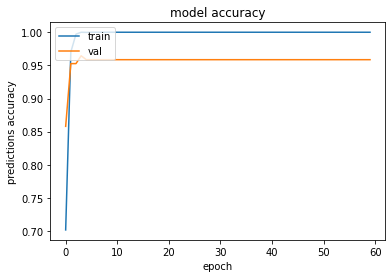

In [34]:
def accuracy_chart():
  plt.plot(history['accuracy'])
  plt.plot(history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('predictions accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

accuracy_chart()

Model loss chart

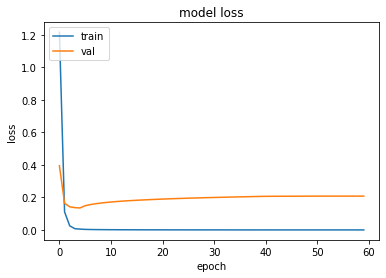

In [35]:
def loss_chart():
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

loss_chart()

Evaluate the results

In [155]:
results = model.evaluate(test_dataset, batch_size=Constants.BATCH_SIZE)
print("Test loss, test accuracy:", results)

6/6 [==============================] - 2s 117ms/step - loss: 0.2743 - accuracy: 0.9529 - top_k_categorical_accuracy: 1.0000
Test loss, test accuracy: [0.27431169152259827, 0.9528796076774597, 1.0]


Predict using test set

In [156]:
TEST_SET_SIZE = 191

def dataset_to_numpy_util(dataset, N):
  dataset = dataset.unbatch().batch(N)
  for images, labels in dataset:
      numpy_images = images.numpy()
      numpy_labels = labels.numpy()
      break;  
  return numpy_images, numpy_labels

images, labels = dataset_to_numpy_util(test_dataset, TEST_SET_SIZE)

# Predict
predictions = model.predict(images)

Show prediction result

In [182]:
CLASSES = test_dataset.class_names

def title_from_label_and_target(prediction_label, expected_label):
  one_hot_label = np.argmax(prediction_label, axis=-1)
  one_hot_expected_label = np.argmax(expected_label, axis=-1)
  correct = (one_hot_label == one_hot_expected_label)
  return CLASSES[one_hot_label], correct, (CLASSES[one_hot_expected_label] if not correct else '')

def show_predictions(images, predictions, labels):
  from tabulate import tabulate
  results = list()
  score = list()
  for i, image in enumerate(images):
    class_name, correct, should_be = title_from_label_and_target(predictions[i], labels[i])
    results.append([class_name, bool(correct), should_be])
    score.append(bool(correct))
  results.sort()
  print(tabulate(results, headers=['Class name', 'Correct?', 'Shoud be?']))

show_predictions(images, predictions, labels)

Class name                    Correct?    Shoud be?
----------------------------  ----------  ------------------------
apis_cerana                   True
apis_cerana                   True
apis_cerana                   True
apis_cerana                   True
apis_dorsata                  True
apis_dorsata                  True
apis_dorsata                  True
apis_dorsata                  True
apis_mellifera                True
apis_mellifera                True
apis_mellifera                True
apis_mellifera                True
apis_mellifera                True
apisflorea                    True
apisflorea                    True
apisflorea                    True
apisflorea                    True
austroplebeia_australis       False       austroplebeia_essinatoni
austroplebeia_australis       False       austroplebeia_striped
austroplebeia_australis       True
austroplebeia_australis       True
austroplebeia_australis       True
austroplebeia_cincta          True
austroplebeia_c

Calculate hits

In [180]:
success = round(results[1] * TEST_SET_SIZE)
fail = TEST_SET_SIZE - success
print(f'Succeeded in {success} images and failed {fail} images')

Succeeded in 182 images and failed 9 images
